# ESA Biomass Climate Change Initiative global forest aboveground biomass dataset v2.0 2010, 2017, 2018

#### Data download: https://catalogue.ceda.ac.uk/uuid/84403d09cef3485883158f4df2989b0c

### Dataset details:
This global dataset is divided into 10x10 degree tiles, consisting of two files per tile: aboveground biomass density, and standard deviation of aboveground biomass density, both expressed in Mg/ha.
All files have a spatial resolution of approximately 100 meters per pixel at the equator.




#### Install these R packages first, and load them into the R session. Source R script with support functions.

In [1]:
packages <- c("raster", "rgdal", "rgeos", "geosphere","RColorBrewer","gdalUtils","ff","parallel", "snow")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})

# source('/projects/shared-buckets/minord/biomass_support.R')
source('/projects/shared-buckets/leitoldv/biomass_support2.R')

Loading required package: raster

Loading required package: sp

Loading required package: rgdal

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.3.2, released 2021/09/01
Path to GDAL shared files: /opt/conda/envs/r-with-gdal/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.0.1, March 5th, 2021, [PJ_VERSION: 801]
Path to PROJ shared files: /opt/conda/envs/r-with-gdal/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Loading required package: rgeos

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rgeos’”
also installing the dependencies ‘foreign’, ‘maptools’, ‘maps’


Updating HTML index of packages in '.Library'

Making 'packages.

#### Set the path to the CCI, JPL, and NCEO Biomass data folders & read in world countries shapefile

In [2]:
#CCI Biomass v3.0
cci_folder <- "/projects/shared-buckets/minord/data/cci_biomass/v3.0"

#JPL Biomass
jpl_folder <- "/projects/shared-buckets/alanxuliang/AGB_2020_v0"

#NCEO Biomass
nceo_folder <- "/projects/shared-buckets/minord/data/nceo_africa_biomass/clipped"

#Country polygons
world <- readOGR("/projects/shared-buckets/leitoldv/NaturalEarth/ne_10m_admin_0_countries.shp")

#Hansen forest cover, resampled to CCI Biomass and JPL resolutions
gfc_folder <- "/projects/my-public-bucket/gfc_data_resampled"

OGR data source with driver: ESRI Shapefile 
Source: "/projects/shared-buckets/leitoldv/NaturalEarth/ne_10m_admin_0_countries.shp", layer: "ne_10m_admin_0_countries"
with 255 features
It has 94 fields
Integer64 fields read as strings:  POP_EST NE_ID 


#### Generate 10x10 degree WGS84 grid that the CCI Biomass and Hansen Forest Cover products are tiled on

In [3]:
gt <- GridTopology(c(-180 + 5, -60 + 5), c(10, 10), c(36,14))
grd <- SpatialGrid(gt, proj4string="+init=epsg:4326")
spix <- as(grd, "SpatialPixels")
spol <- as(spix, "SpatialPolygons")
cci_tiles <- spol

Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


#### Print out country names in Africa to select from

In [4]:
Cont <- world[world$CONTINENT=="Africa",]
Cont$ADMIN
Cont$ADM0_A3

[1] "Ethiopia"                         "South Sudan"                     
 [3] "Somalia"                          "Kenya"                           
 [5] "Malawi"                           "United Republic of Tanzania"     
 [7] "Somaliland"                       "Morocco"                         
 [9] "Western Sahara"                   "Republic of the Congo"           
[11] "Democratic Republic of the Congo" "Namibia"                         
[13] "South Africa"                     "Libya"                           
[15] "Tunisia"                          "Zambia"                          
[17] "Sierra Leone"                     "Guinea"                          
[19] "Liberia"                          "Central African Republic"        
[21] "Sudan"                            "Djibouti"                        
[23] "Eritrea"                          "Ivory Coast"                     
[25] "Mali"                             "Senegal"                         
[27] "Nigeria"                          "Benin"                           
[29] "Angola"                           "Botswana"                        
[31] "Zimbabwe"                         "Chad"                            
[33] "Algeria"                          "Mozambique"                      
[35] "eSwatini"                         "Burundi"                         
[37] "Rwanda"                           "Uganda"                          
[39] "Lesotho"                          "Cameroon"                        
[41] "Gabon"                            "Niger"                           
[43] "Burkina Faso"                     "Togo"                            
[45] "Ghana"                            "Guinea-Bissau"                   
[47] "Egypt"                            "Mauritania"                      
[49] "Equatorial Guinea"                "Gambia"                          
[51] "Madagascar"                       "Comoros"                         
[53] "São Tomé and Principe"            "Cabo Verde"

[1] "ETH" "SDS" "SOM" "KEN" "MWI" "TZA" "SOL" "MAR" "SAH" "COG" "COD" "NAM"
[13] "ZAF" "LBY" "TUN" "ZMB" "SLE" "GIN" "LBR" "CAF" "SDN" "DJI" "ERI" "CIV"
[25] "MLI" "SEN" "NGA" "BEN" "AGO" "BWA" "ZWE" "TCD" "DZA" "MOZ" "SWZ" "BDI"
[37] "RWA" "UGA" "LSO" "CMR" "GAB" "NER" "BFA" "TGO" "GHA" "GNB" "EGY" "MRT"
[49] "GNQ" "GMB" "MDG" "COM" "STP" "CPV"

#### Select a country in Africa to plot with corresponding data tiles

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

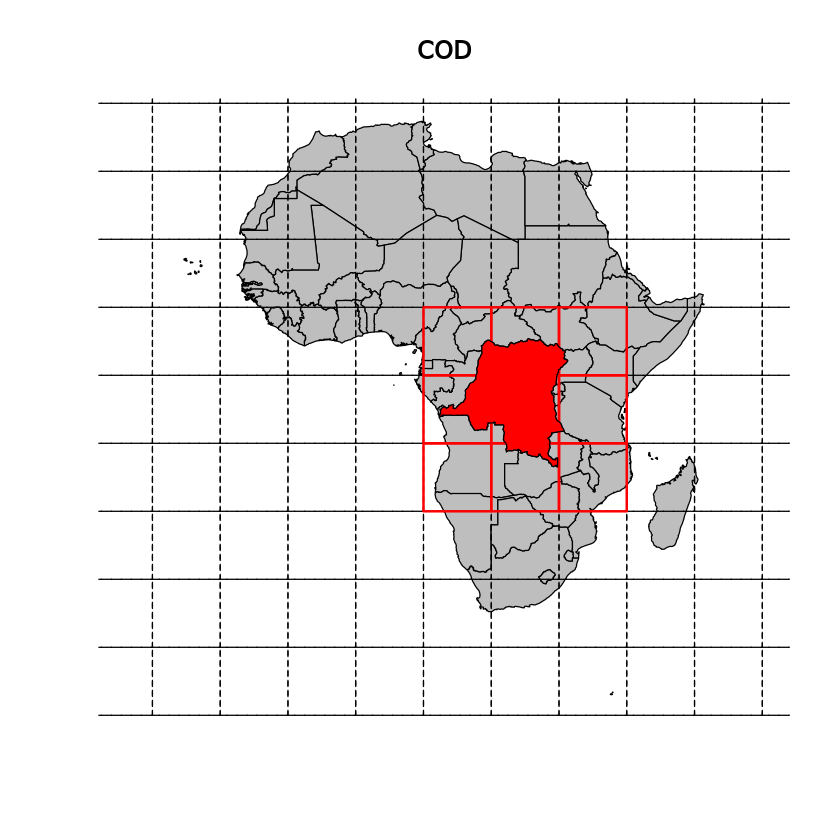

In [5]:
iso3 <- c("COD") ## Democratic Republic of the Congo (COD)
aoi <- world[world$ADM0_A3 %in% iso3,]

crs(aoi)
crs(cci_tiles)

if (!identical(crs(aoi), crs(cci_tiles))){aoi <- spTransform(aoi, crs(cci_tiles))}
intersecting <- as.logical(gIntersects(cci_tiles, gConvexHull(aoi), byid=TRUE) & !gTouches(cci_tiles, gConvexHull(aoi), byid=TRUE))
  if (sum(intersecting) == 0) {stop('no intersecting CCI Biomass tiles found')
  } else {
    tiles <- cci_tiles[intersecting,]
  }

plot(Cont, col="gray", main=iso3)
plot(cci_tiles, lty=2, add=T)
plot(tiles, lwd=2, border="red", add=T)
plot(aoi, col="red", add=T)

In [6]:
# Transform aoi to match tiles CRS so it can be used later for cropping
aoi <- spTransform(aoi, crs(tiles))

#### Read in the CCI Biomass data for this AOI from the downloaded CCI Biomass tiles, mosaicing multiple tiles as necessary

In [7]:
cci <- readCCI_v2(data_folder=cci_folder, year="2020", version=3, aoi=aoi)
cci

class      : RasterBrick 
dimensions : 21188, 21454, 454567352, 2  (nrow, ncol, ncell, nlayers)
resolution : 0.0008888889, 0.0008888889  (x, y)
extent     : 12.21067, 31.28089, -13.45867, 5.375111  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : r_tmp_2022-01-26_200233_352_68632.tif 
names      : agbd_2020, agbd_sd_2020 
min values :         0,            0 
max values :       552,         1068 


#### Plot the CCI AGBD for 2020

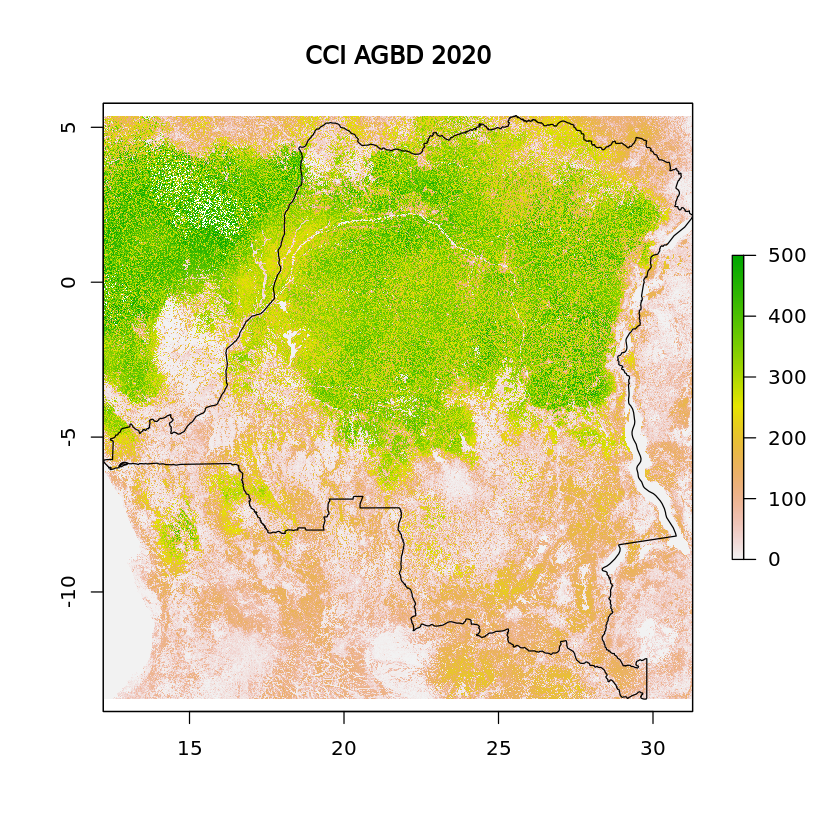

In [8]:
plot(cci$agbd_2020, main="CCI AGBD 2020", zlim=c(0,500)); plot(aoi, add=T)

#### Read in the NCEO Biomass data for this AOI from the downloaded data. NCEO data is stored as a single file for the continent of Africa, rather than multiple tiles.

In [9]:
nceo_file <- 'AGB_map_2017v0m.tif'
# nceo_sd_file <- 'SD_map_2017v0m.tif'

band_names_nceo <- c(paste0('agbd_2017'))   #, paste0('agbd_sd_2017'))
filenames_nceo <- c(file.path(nceo_folder, nceo_file))  #, file.path(nceo_folder, nceo_sd_file))
print(filenames_nceo)

tile_stack <- crop(stack(filenames_nceo), aoi)#datatype="INT1U", format='GTiff', options="COMPRESS=LZW")

names(tile_stack) <- band_names_nceo
tile_stacks <- list(tile_stack)


tile_mosaic <- tile_stacks[[1]]
     
names(tile_mosaic) <- band_names_nceo
NAvalue(tile_mosaic) <- -1

nceo <- tile_mosaic
nceo

[1] "/projects/shared-buckets/minord/data/nceo_africa_biomass/clipped/AGB_map_2017v0m.tif"


class      : RasterBrick 
dimensions : 20966, 21228, 445066248, 1  (nrow, ncol, ncell, nlayers)
resolution : 0.0008983153, 0.0008983153  (x, y)
extent     : 12.2108, 31.28024, -13.45856, 5.375519  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : r_tmp_2022-01-26_200914_352_19081.grd 
names      : agbd_2017 
min values :         0 
max values :       730 


#### Plot the NCEO AGBD for 2017

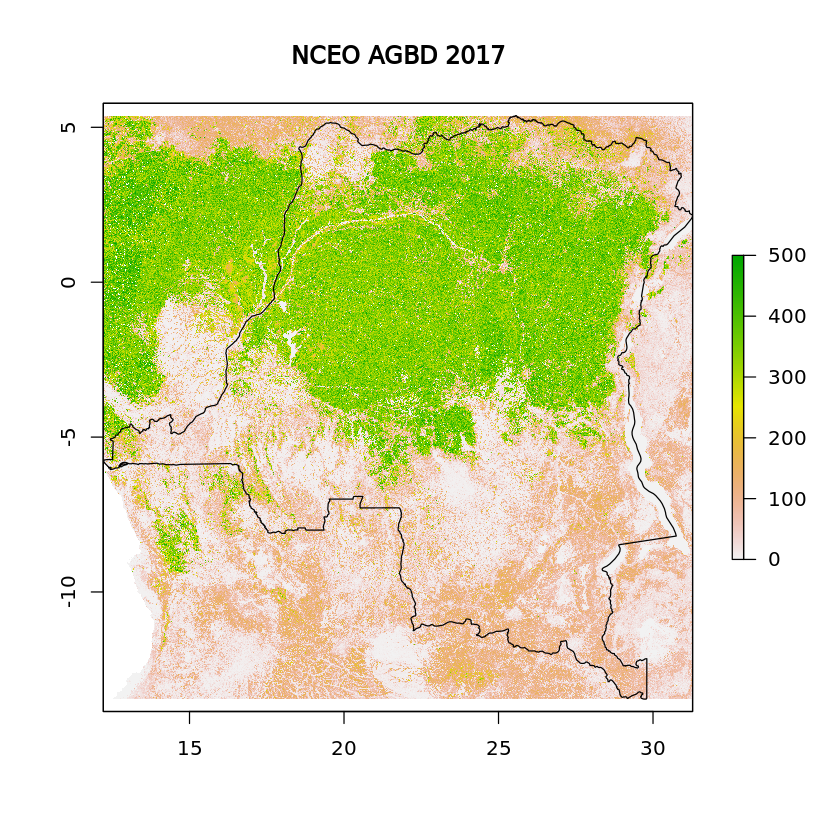

In [10]:
plot(nceo$agbd_2017, main="NCEO AGBD 2017", zlim = c(0,500) ); plot(aoi, add=T)
# plot(nceo$agbd_sd_2017, main="NCEO AGBD SD 2017", zlim = c(0,300) ); plot(aoi, add=T)

#### Read in the JPL Biomass data for this AOI

In [11]:
file_name <- paste0('global_008_agb_mean_prediction_2020_mosaic_veg_gfccorr_Africa.tif')

band_names_jpl <- c(paste0('agbd_2020'))#, paste0('agbd_sd_2020'))
filenames_jpl <- c(file.path(jpl_folder, file_name))#, file.path(jpl_folder, 'error_maps', file_name_sd))
print(filenames_jpl)

filename <- ""

tile_stack <- crop(stack(filenames_jpl), aoi)

names(tile_stack) <- band_names_jpl
tile_stacks <- list(tile_stack)

tile_mosaic <- tile_stacks[[1]]
  if (filename != '') {
    tile_mosaic <- writeRaster(tile_mosaic, filename=filename, 
                               datatype="INT1U", format="GTiff", 
                               options="COMPRESS=LZW")
  }    
      
names(tile_mosaic) <- band_names_jpl
NAvalue(tile_mosaic) <- -1

jpl <- tile_mosaic
jpl

[1] "/projects/shared-buckets/alanxuliang/AGB_2020_v0/global_008_agb_mean_prediction_2020_mosaic_veg_gfccorr_Africa.tif"


class      : RasterBrick 
dimensions : 20966, 21228, 445066248, 1  (nrow, ncol, ncell, nlayers)
resolution : 0.0008983153, 0.0008983153  (x, y)
extent     : 12.2108, 31.28024, -13.45856, 5.375519  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : r_tmp_2022-01-26_201016_352_96449.grd 
names      : agbd_2020 
min values :         0 
max values :     24186 


In [12]:
## Update JPL biomass values to correct unit (biomass = DN/10 in tons/ha)
jpl_corr <- 0.1 * subset(jpl, 1)
jpl_corr[jpl_corr < 0] <- NA
jpl_corr[jpl_corr > 2000] <- NA
names(jpl_corr) <- c('agbd_2020')
jpl_corr

class      : RasterLayer 
dimensions : 20966, 21228, 445066248  (nrow, ncol, ncell)
resolution : 0.0008983153, 0.0008983153  (x, y)
extent     : 12.2108, 31.28024, -13.45856, 5.375519  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : r_tmp_2022-01-26_201501_352_96492.grd 
names      : agbd_2020 
values     : 0, 1997.5  (min, max)


#### Plot the JPL AGBD for 2020

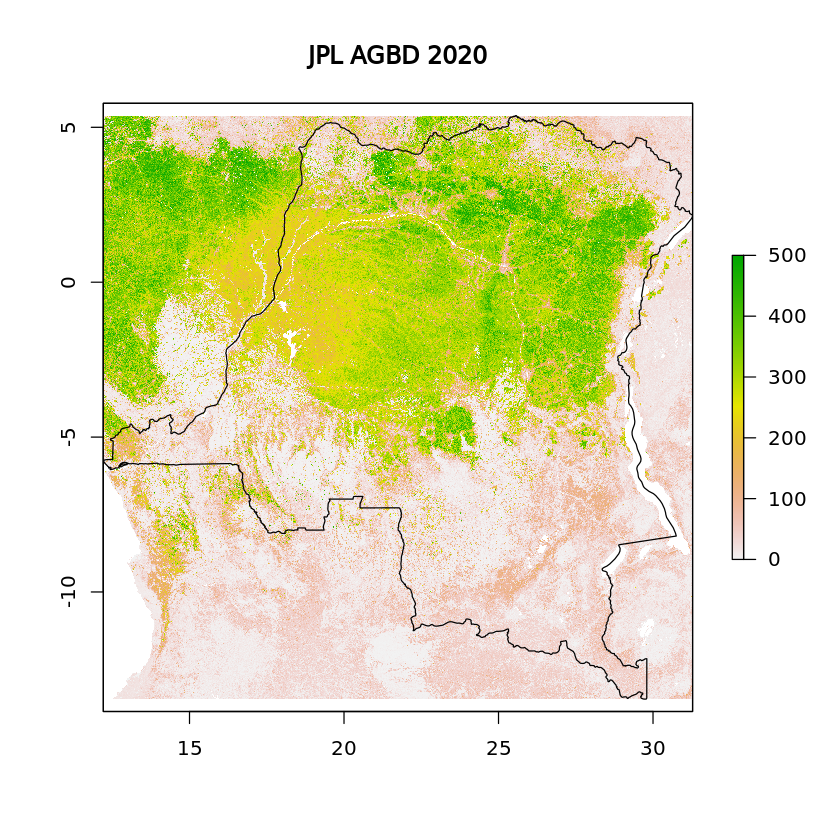

In [13]:
plot(jpl_corr$agbd_2020, main="JPL AGBD 2020", zlim=c(0,500)); plot(aoi, add=T)

#### Read in forest cover raster. Currently using 30% forest cover from Hansen product. The cover rasters have been resampled to the resolutions of CCI Biomass, JPL Biomass, and NCEO Biomass for use as a forest cover mask.

In [14]:
gfc_cci <- readGFC(data_folder=file.path(gfc_folder,"cci"), image='treecover2020', aoi=aoi)
gfc_jpl <- readGFC(data_folder=file.path(gfc_folder,"jpl"), image='treecover2020', aoi=aoi)
gfc_nceo <- readGFC(data_folder=file.path(gfc_folder, "nceo"), image='treecover2020', aoi=aoi)

#### Create 10% cover forest threshold mask for CCI, JPL, and NCEO (or set desired % below)

In [15]:
recode_gfc2020 <- function(treecover2020) {
    forest_threshold <- 10
    forest2020 <- treecover2020 > forest_threshold
    thresholded <- matreix(c(forest2020),
                          nrow=length(forest2020),
                          ncol=1)
    return(thresholded)
  }

#### Create cover forest threshold mask for CCI

In [16]:
system.time({
beginCluster(n=5)
    gfc_cci_thresholded <- clusterR(gfc_cci, overlay, arg = list(fun = recode_gfc2020))
endCluster()
})

ERROR: Error in clusterR(gfc_cci, overlay, arg = list(fun = recode_gfc2020)): cluster error


Timing stopped at: 0.313 0.64 5.037



#### Create cover forest threshold mask for JPL

In [ ]:
system.time({
beginCluster(n=5)
    gfc_jpl_thresholded <- clusterR(gfc_jpl, overlay, arg = list(fun = recode_gfc2020))
endCluster()
})

#### Create cover forest threshold mask for NCEO

In [ ]:
system.time({
beginCluster(n=5)
    gfc_nceo_thresholded <- clusterR(gfc_nceo, overlay, arg = list(fun = recode_gfc2020))
endCluster()
})

In [ ]:
names(gfc_cci_thresholded) <- c('forest2020')
names(gfc_jpl_thresholded) <- c('forest2020')
names(gfc_nceo_thresholded) <- c('forest2020')

### Checkpoint: Write out and read in Forest cover threshold mask for CCI and JPL

In [ ]:
save_folder = "/projects/my-public-bucket/data/gfc_threshold"

filename<-file.path(save_folder, paste('gfc_cci_thresholded', aoi@data$SOVEREIGNT, sep="_"))
writeRaster(gfc_cci_thresholded, filename=filename, format="GTiff", overwrite=TRUE)

filename<-file.path(save_folder, paste('gfc_jpl_thresholded', aoi@data$SOVEREIGNT, sep="_"))
writeRaster(gfc_jpl_thresholded, filename=filename, format="GTiff", overwrite=TRUE)

filename<-file.path(save_folder, paste('gfc_nceo_thresholded', aoi@data$SOVEREIGNT, sep="_"))
writeRaster(gfc_nceo_thresholded, filename=filename, format="GTiff", overwrite=TRUE)

In [ ]:
threshold_folder = "/projects/shared-buckets/tkerr1/data/gfc_threshold"

filename<-file.path(threshold_folder, paste0('gfc_cci_thresholded_', aoi@data$SOVEREIGNT, ".tif"))
gfc_cci_thresholded <- raster(x=filename, format="GTiff")

filename<-file.path(threshold_folder, paste0('gfc_jpl_thresholded_', aoi@data$SOVEREIGNT, ".tif"))
gfc_jpl_thresholded <- raster(x=filename, format="GTiff")

filename<-file.path(threshold_folder, paste0('gfc_nceo_thresholded_', aoi@data$SOVEREIGNT, ".tif"))
gfc_nceo_thresholded <- raster(x=filename, format="GTiff")

names(gfc_cci_thresholded) <- c('forest2020')
names(gfc_jpl_thresholded) <- c('forest2020')
names(gfc_nceo_thresholded) <- c('forest2020')

#### Apply the forest cover threshold mask to CCI, JPL, and NCEO

In [ ]:
cci_thresholded <- mask(x=cci$agbd_2020, mask=gfc_cci_thresholded$forest2020, inverse=TRUE, maskvalue=1)
cci_thresholded

In [ ]:
plot(cci$agbd_2020, zlim=c(0,500), main="CCI biomass"); plot(aoi, add=T)
plot(gfc_cci_thresholded$forest2020, main="forest mask"); plot(aoi, add=T)
plot(cci_thresholded$agbd_2020, zlim=c(0,300), main="CCI masked"); plot(aoi, add=T)

In [ ]:
jpl_thresholded <- mask(x=jpl_corr$agbd_2020, mask=gfc_jpl_thresholded$forest2020, inverse=T, maskvalue=1)
jpl_thresholded

In [ ]:
plot(jpl_corr$agbd_2020, zlim=c(0,500), main="JPL biomass"); plot(aoi, add=T)
plot(gfc_jpl_thresholded$forest2020, main="forest mask"); plot(aoi, add=T)
plot(jpl_thresholded, zlim=c(0,500), main="JPL masked"); plot(aoi, add=T)

In [ ]:
nceo_thresholded <- mask(x=nceo$agbd_2017, mask=gfc_nceo_thresholded$forest2020, inverse=T, maskvalue=1)
nceo_thresholded

In [ ]:
plot(nceo$agbd_2017, zlim=c(0,500), main="NCEO biomass"); plot(aoi, add=T)
plot(gfc_nceo_thresholded$forest2020, main="forest mask"); plot(aoi, add=T)
plot(nceo_thresholded, zlim=c(0,500), main="NCEO masked"); plot(aoi, add=T)

### Checkpoint: Write out and read in Forest only biomass for CCI, JPL, and NCEO

In [ ]:
save_folder = "/projects/my-public-bucket/data/gfc_threshold"

filename<-file.path(save_folder, paste('cci_thresholded', aoi@data$SOVEREIGNT, sep="_"))
writeRaster(cci_thresholded, filename=filename, format="GTiff", overwrite=TRUE)

filename<-file.path(save_folder, paste('jpl_thresholded', aoi@data$SOVEREIGNT, sep="_"))
writeRaster(jpl_thresholded, filename=filename, format="GTiff", overwrite=TRUE)

filename<-file.path(save_folder, paste('nceo_thresholded', aoi@data$SOVEREIGNT, sep="_"))
writeRaster(nceo_thresholded, filename=filename, format="GTiff", overwrite=TRUE)

In [ ]:
threshold_folder = "/projects/shared-buckets/tkerr1/data/gfc_threshold"

filename <- file.path(threshold_folder, paste0('cci_thresholded_', aoi@data$SOVEREIGNT, ".tif"))
cci_thresholded <- raster(x=filename)

filename <- file.path(threshold_folder, paste0('jpl_thresholded_', aoi@data$SOVEREIGNT, ".tif"))
jpl_thresholded <- raster(x=filename)

filename <- file.path(threshold_folder, paste0('nceo_thresholded_', aoi@data$SOVEREIGNT, ".tif"))
nceo_thresholded <- raster(x=filename)

names(cci_thresholded) <- c('agbd_2020')
names(jpl_thresholded) <- c('agbd_2020')
names(nceo_thresholded) <- c('agbd_2020')

#### Mask to country shape

In [ ]:
cci_masked <- mask(cci_thresholded, aoi, updatevalue=NA)

In [ ]:
jpl_masked <- mask(jpl_thresholded, aoi, updatevalue=NA)

In [ ]:
nceo_masked <- mask(nceo_thresholded, aoi, updatevalue=NA)

In [ ]:
names(cci_masked) <- c('agbd_2020')
names(jpl_masked) <- c('agbd_2020')
names(nceo_masked) <- c('agbd_2020')

#### Plot forest biomass map and histogram of biomass density for CCI, JPL, and NCEO

In [ ]:
par(mfrow=c(2,2), mai=c(0.5,0.5,0.5,0.5))
options(repr.plot.width=15, repr.plot.height=15)

plot(cci_masked$agbd_2020, main="CCI AGBD 2020 (cover>30%)", zlim=c(0,500) ); plot(aoi, add=T)

val.cci2020 <- ff(getValues(cci_masked$agbd_2020))
hist(val.cci2020[,3][val.cci2020[,3]>0], freq=F,
     breaks=seq(0,round(max(getValues(cci_masked$agbd_2020),na.rm=T),digits=-1)+10,10),
     main="CCI AGBD 2020", xlab="AGBD (Mg/Ha)", xlim=c(0,500), ylim=c(0,0.01))


plot(jpl_masked$agbd_2020, main="JPL AGBD 2020 (cover>30%)", zlim=c(0,500) ); plot(aoi, add=T)

val.jpl2020 <- ff(getValues(jpl_masked$agbd_2020))
hist(val.jpl2020[,3][val.jpl2020[,3]>0], freq=F,
     breaks=seq(0,round(max(getValues(jpl_masked$agbd_2020),na.rm=T),digits=-1)+10,10),
     main="JPL AGBD 2020", xlab="AGBD (Mg/Ha)", xlim=c(0,500), ylim=c(0,0.01))

plot(nceo_masked$agbd_2020, main="NCEO AGBD 2020 (cover>30%)", zlim=c(0,500) ); plot(aoi, add=T)

val.nceo2020 <- ff(getValues(nceo_masked$agbd_2020))
hist(val.nceo2020[,3][val.nceo2020[,3]>0], freq=F,
     breaks=seq(0,round(max(getValues(nceo_masked$agbd_2020),na.rm=T),digits=-1)+10,10),
     main="NCEO AGBD 2020", xlab="AGBD (Mg/Ha)", xlim=c(0,500), ylim=c(0,0.01))

#### Calculate total aboveground biomass and average aboveground biomass density for 2020 CCI and JPL biomass for the selected country

In [ ]:
cci_table <- agbd_table(year=2020, agb_thresholded=cci_thresholded, agb_masked=cci_masked)
jpl_table <- agbd_table(year=2020, agb_thresholded=jpl_thresholded, agb_masked=jpl_masked)
nceo_table <- agbd_table(year=2020, agb_thresholded=nceo_thresholded, agb_masked=nceo_masked)

#### Print out basic forest aboveground biomass statistics for the selected country


In [ ]:
aoi_area <- area(aoi)/10^6 ##km2
cci_forest2020_agb <- cci_table[cci_table[,"year"]==2020,"agb"]/10^9  ##petagram
cci_forest2020_agbd <- cci_table[cci_table[,"year"]==2020,"agbd"]  
jpl_forest2020_agb <- jpl_table[jpl_table[,"year"]==2020,"agb"]/10^9  ##petagram
jpl_forest2020_agbd <- jpl_table[jpl_table[,"year"]==2020,"agbd"]
nceo_forest2020_agb <- nceo_table[nceo_table[,"year"]==2020,"agb"]/10^9  ##petagram
nceo_forest2020_agbd <- nceo_table[nceo_table[,"year"]==2020,"agbd"]

print(paste("Country name:", aoi@data$SOVEREIGNT, sep=" "))
print(paste("Country area:", round(aoi_area, digits=2), "km2", sep=" "))
print(paste("Total CCI forest biomass 2020:", round(cci_forest2020_agb, digits=2), "Pg", sep=" "))
print(paste("Total JPL forest biomass 2020:", round(jpl_forest2020_agb, digits=2), "Pg", sep=" "))
print(paste("Total NCEO forest biomass 2020:", round(nceo_forest2020_agb, digits=2), "Pg", sep=" "))
print(paste("Mean CCI forest biomass density 2020:", round(cci_forest2020_agbd, digits=2), "Mg/ha", sep=" "))
print(paste("Mean JPL forest biomass density 2020:", round(jpl_forest2020_agbd, digits=2), "Mg/ha", sep=" "))
print(paste("Mean NCEO forest biomass density 2020:", round(nceo_forest2020_agbd, digits=2), "Mg/ha", sep=" "))

## The following is old code I'm keeping here for reference purposes

#### Calculate total aboveground biomass and average aboveground biomass density for 2020 CCI and NCEO biomass for the selected country

In [23]:
# agb_summary <- function(agb_raster, data_name, aoi, scale_factor, year){

#     #scale_factor=0.0001
#     #dataset <- 'CCIBiomass-2018-v2.0'

#     boundpoly <- as(extent(agb_raster), 'SpatialPolygons')
#     proj4string(boundpoly) <- proj4string(agb_raster)
#     boundpoly_wgs84 <- spTransform(boundpoly, CRS('+init=epsg:4326'))
#     aoi_wgs84 <- spTransform(aoi, CRS('+init=epsg:4326'))
#     if (!gIntersects(boundpoly_wgs84, aoi_wgs84)) {
#       stop('aoi does not intersect supplied CCI Biomass extract')
#     }

#     if ((((xmin(agb_raster) >=-180) & (xmax(agb_raster) <=180)) || ((xmin(agb_raster) >=0) & (xmax(agb_raster) <=360))) &&
#         (ymin(agb_raster) >=-90) & (ymax(agb_raster) <= 90)) {
#       # Use the included calc_pixel_area function to calculate the area of 
#       # one cell in each line of the raster, allowing for accurate areal 
#       # estimates in square meters even when imagery is in 
#       # WGS84.
#       message('Data appears to be in latitude/longitude. Calculating cell areas on a sphere.')
#       spherical_areas <- TRUE
#       # Calculate the area of a single pixel in each line of the image (to 
#       # avoid repeating this calculation later on)
#       x <- agb_raster
#       xleft <- xmin(x)
#       xright <- xmin(x) + xres(x)
#       ylower <- seq(from=(ymax(x) - yres(x)), by=(-yres(x)), length.out=nrow(x))
#       yupper <- seq(from=ymax(x), by=(-yres(x)), length.out=nrow(x))
#       poly_areas <- function(xl, xr, yl, yu) {
#       areaPolygon(matrix(c(xl, yl,
#                            xr, yl,
#                            xr, yu,
#                            xl, yu), ncol=2, byrow=TRUE))
#                           }
#       pixel_areas <- mapply(poly_areas, xleft, xright, ylower, yupper)
    
#     } else {
#       spherical_areas <- FALSE
#       pixel_areas <- xres(agb_raster) * yres(agb_raster)
#     }
    
#     aoi <- spTransform(aoi, CRS(proj4string(agb_raster)))
#     if (!('label' %in% names(aoi))) {
#       aoi$label <- paste('AOI', seq(1:nrow(aoi@data)))
#     }
    
#     uniq_aoi_labels <- unique(aoi$label)


#     years <- as.numeric(year)

#     agb_table <- data.frame(year=rep(years, length(uniq_aoi_labels)),
#                          aoi=rep(uniq_aoi_labels, each=length(years)))
#     agb_table$agb <- 0
#     agb_table$agbd <- 0
#     agb_table$agbd_sd <- 0

#     n_years <- length(years)



#     for (n in 1:nrow(aoi)) {
#       raster_masked <- mask(agb_raster, aoi[n, ], datatype='INT1U', format="GTiff", 
#                          options="COMPRESS=LZW")
  
#       # Find the first row in the loss table that applies to this aoi
#       agb_table_st_row <- match(aoi[n, ]$label, agb_table$aoi)
#       # No loss in first year
#       #agb_table$agb[loss_table_st_row] <- NA
  
  
#       # Process by blocks to avoid unnecessary reads from disk
#       bs <- blockSize(raster_masked)
#       for (block_num in 1:bs$n) {
#         bl_st_row <- bs$row[block_num]
#         bl_nrows <- bs$nrows[block_num]
#         raster_masked_bl <- getValuesBlock(raster_masked, bl_st_row, bl_nrows)
        
#         if (spherical_areas) {
#           bl_pixel_areas <- rep(pixel_areas[bl_st_row:(bl_st_row + bl_nrows - 1)], each=ncol(agb_raster))
#         } else {
#           bl_pixel_areas <- pixel_areas
#         }
    
#         # Calculate initial aboveground biomass, note that areas are converted to square 
#         # meters using pixel size, then converted using scale_factor 
#         # (default output units are Mg)
#      #   agbinit_col <- grep(paste0('agb_',year[1]), names(cci))
#      #   agb_table$agb[agb_table_st_row] <- agb_table$agb[agb_table_st_row] +
#      #     sum(cci_bl[, agbinit_col] * bl_pixel_areas * scale_factor, na.rm=TRUE)
#      #   agb_table$agbd[agb_table_st_row + i] <- agb_table$agbd[agb_table_st_row + i] +
#      #       mean((cci_bl[, agb_col] == i), na.rm=TRUE)  
        
#         for (i in 0:(n_years-1)) {
#           agbd_col <- grep(paste0('agbd_',year[i+1]), names(agb_raster))
#           sd_col <- grep(paste0('agbd_sd_',year[i+1]), names(agb_raster))

#           agb_table$agb[agb_table_st_row + i] <- agb_table$agb[agb_table_st_row + i] +
#             sum(raster_masked_bl[, agbd_col] * bl_pixel_areas * scale_factor, na.rm=TRUE) 
        
#           agb_table$area[agb_table_st_row + i] <- agb_table$area[agb_table_st_row + i] +
#             sum((!is.na(raster_masked_bl[, agbd_col]))*bl_pixel_areas * scale_factor, na.rm=TRUE)   
        
#           agb_table$n_pixel[agb_table_st_row + i] <- agb_table$n_pixel[agb_table_st_row + i] +
#             sum(!is.na(raster_masked_bl[, agbd_col]))     
        
#           if(bl_st_row==1){
#               agb_table$agbd[agb_table_st_row + i] <- mean(raster_masked_bl[, agbd_col], na.rm=TRUE)
#               agb_table$agbd_sd[agb_table_st_row + i] <- mean(raster_masked_bl[, sd_col], na.rm=TRUE)
#           }  else{
#               agb_table$agbd[agb_table_st_row + i] <- weighted.mean(c(agb_table$agbd[agb_table_st_row + i], 
#                 mean(raster_masked_bl[, agbd_col], na.rm=TRUE)), w=c((bl_st_row-1), bl_nrows), na.rm=TRUE)
#               agb_table$agbd_sd[agb_table_st_row + i] <- weighted.mean(c(agb_table$agbd_sd[agb_table_st_row + i], 
#                 mean(raster_masked_bl[, sd_col], na.rm=TRUE)), w=c((bl_st_row-1), bl_nrows), na.rm=TRUE)
#           }
        
      
      
#         }
      

   
#       }
  
    
 
  
#     }
#     colnames(agb_table)[3:5] <- paste(colnames(agb_table)[3:5], data_name, sep="_")
#     return(agb_table)
# }    
# cci_table <- agb_summary(agb_raster=cci, data_name="CCI", aoi=aoi, scale_factor=0.0001, year="2020")
# nceo_table <- agb_summary(agb_raster=nceo, data_name="NCEO", aoi=aoi, scale_factor=0.0001, year="2017")

# agb_table <- dplyr::full_join(cci_table, nceo_table, by=c("year","aoi"))
# agb_table

Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”
Data appears to be in latitude/longitude. Calculating cell areas on a sphere.

Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”
Data appears to be in latitude/longitude. Calculating cell areas on a sphere.



year,aoi,agb_CCI,agbd_CCI,agbd_sd_CCI,agb_NCEO,agbd_NCEO,agbd_sd_NCEO
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,AOI 1,15721489565,116.8332,99.37238,NA,NA,NA
2017,AOI 1,NA,NA,NA,8378359251,77.45101,71.80152


#### Print out basic forest aboveground biomass statistics for the selected country
Note: The quantification of AGB changes by taking the difference of two maps is strongly discouraged due to local biases and uncertainties. It is done here for demonstration purposes only. Version 3 maps will ensure a more realistic representation of AGB changes.

In [24]:
# crs(cci)
# crs(nceo)

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

In [26]:
# for(i in 1:nrow(aoi@data)){

#     if (!('label' %in% names(aoi))) {
#       aoi$label <- paste('AOI', seq(1:nrow(aoi@data)))
#     }
#     aoi_label <- unique(aoi$label)[i]
    
#     aoi_area <- area(aoi)[i]/10^6 ##km2
#     cci_2020_agb <- agb_table[agb_table[,"year"]==2020 & agb_table[,"aoi"]==aoi_label,"agb_CCI"]/10^9  ##petagram
#     nceo_2017_agb <- agb_table[agb_table[,"year"]==2017 & agb_table[,"aoi"]==aoi_label,"agb_NCEO"]/10^9  ##petagram
#     cci_2020_agbd <- agb_table[agb_table[,"year"]==2020 & agb_table[,"aoi"]==aoi_label,"agbd_CCI"]  
#     nceo_2017_agbd <- agb_table[agb_table[,"year"]==2017 & agb_table[,"aoi"]==aoi_label,"agbd_NCEO"]  

#     print(paste("Country name:", aoi@data$SOVEREIGNT[i], sep=" "))
#     print(paste("Country area:", round(aoi_area, digits=2), "km2", sep=" "))
#     print(paste("Total biomass estimate CCI 2020:", round(cci_2020_agb, digits=2), "Pg", sep=" "))
#     print(paste("Total biomass estimate NCEO 2017:", round(nceo_2017_agb, digits=2), "Pg", sep=" "))
#     print(paste("Mean biomass density estimate CCI 2020:", round(cci_2020_agbd, digits=2), "Mg/ha", sep=" "))
#     print(paste("Mean biomass density estimate NCEO 2017:", round(nceo_2017_agbd, digits=2), "Mg/ha", sep=" "))
    
# }

# #pal <- colorRampPalette(brewer.pal(3, "RdBu"))
# #nceo <- nceo
# #plot(cci$agbd_2017-nceo$agbd_2017, main="AGBD Difference CCI - NCEO 2017", col=pal(100)); plot(aoi, add=T)


[1] "Country name: Democratic Republic of the Congo"
[1] "Country area: 2325240.42 km2"
[1] "Total biomass estimate CCI 2020: 15.72 Pg"
[1] "Total biomass estimate NCEO 2017: 8.38 Pg"
[1] "Mean biomass density estimate CCI 2020: 116.83 Mg/ha"
[1] "Mean biomass density estimate NCEO 2017: 77.45 Mg/ha"
